***
## Functions
***

In [1]:
import numpy as np
import pandas as pd

In [2]:
def fill_nulls(df, min_limit=0.25, max_limit=0.75):
    # Create empty dictionary to enter column names, null percentage, and filled status
    result = dict()
    
    # Get column name and null percentage from 'df' argument if null percentage exists
    null_cols = [[col, round(df[col].isnull().sum()/df.shape[0],3)]
                 for col in df.columns
                 if df[col].isnull().sum() > 0]
    
    for col in null_cols:
        # If null percentage higher than/equal to max limit, drop column from df
        if col[1] >= max_limit:
            result[col[0]] = {'Filled': False, 
                              'Dropped':True, 
                              'Null_Percentage': col[1]}
            df.drop(columns=col[0], inplace=True)
            
        # If null percentage higher than/equal to min_limit argument, enter into dictionary w/ 'Filled':False
        elif col[1] >= min_limit:    
            result[col[0]] = {'Filled': False, 
                              'Dropped':False, 
                              'Null_Percentage': col[1]}
            
        # If null percentage lower than limit argument, enter into dictionary w/ 'Filled':True, filled type & value
        elif col[1] < min_limit: 
            if df[col[0]].dtypes in ['float', 'int']:
                df[col[0]].fillna(df[col[0]].dropna().median(), inplace=True)
                result[col[0]] = {'Filled': True, 
                                  'Type': 'Median', 
                                  'Fill_Value':df[col[0]].dropna().median(), 
                                  'Null_Percentage': col[1]}
            else:
                df[col[0]].fillna(df[col[0]].dropna().mode()[0], inplace=True)
                result[col[0]] = {'Filled': True, 
                                  'Type': 'Mode', 
                                  'Fill_Value':df[col[0]].dropna().mode()[0], 
                                  'Null_Percentage': col[1]}
                
    # Return dictionary result (although could be pandas dataframe...?)        
    return result

In [3]:
def name_to_title(df, drop=True):
    # Use list of unique titles in Name column to determine accepted titles
    accepted_titles = ['Mr', 'Master', 'Sir', 'Mrs', 'Ms', 'Lady']
    
    # Get titles for each row
    raw_titles = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
    
    # Search for and replace unaccepted titles based on gender
    for idx, title in enumerate(raw_titles):
        if title not in accepted_titles:
            if df.iloc[idx]['Sex'] == 0:
                raw_titles[idx] = 'Ms'
            else:
                raw_titles[idx] = 'Mr'
                
    # Create Title dummies and drop Name column
    df.drop(columns='Name', inplace=True)
    
    # True for model, False for EDA
    if drop:
        title_dummies = pd.get_dummies(raw_titles, drop_first=True, prefix='Title')
    else:
        title_dummies = pd.get_dummies(raw_titles, prefix='Title')
    
    # Concatenate and return df & title_dummies
    return pd.concat([df, title_dummies], axis=1)

In [4]:
def clean_data(df, drop=True, save=False):
    # Fill NaN values if null percentage is below min_limit (0.2); drop if above max_limit(0.75)
    fill_null = fill_nulls(df)
    
    # Turn Sex into bool, and Embarked into dummy var
    df['Sex'] = df['Sex'].map(lambda x: 0 if x == 'female' else 1)
    
    # True for model, False for EDA
    if drop:
        embarked_dummies = pd.get_dummies(df['Embarked'], drop_first=True, prefix='Embarked')
    else:
        embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
    df = pd.concat([df, embarked_dummies], axis=1)
    
    # Drop unnecessary columns - ['PassengerId', 'Ticket', 'Embarked']
    df.drop(columns=['PassengerId', 'Ticket', 'Embarked'], inplace=True)
    
    # Finish cleaning data by transforming Name column to Title dummies
    df_clean = name_to_title(df, drop=drop)
    
    # False, else string directory
    if save:
        df_clean.to_csv(save, index=False)
    
    return fill_null, df_clean

***
## Cleaning
***
- Age, Cabin, and Embarked contain NaN values
    - Use function to fill NaN values below specified percentage (if NaN percentage is below .2, fill; if above .75, remove column)
        - If null percentage lies between limits, may have to take a moment to find best course of action depending on context and importance of given column(s)
        - Age (177) - 19%
        - Cabin (687) - 77%
        - Embarked (2) - 0.2%
    - Age and Embarked filled; Cabin removed
- Create dummy variables with Embarked
- Change Sex to 1/0
- Possibly remove PassengerId and Ticket
- Change Name to Titles

In [5]:
titanic_train = pd.read_csv('data/train.csv')

print(titanic_train.shape)
titanic_train.head(3)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
nulls, df = clean_data(titanic_train)
_, df_noDrop = clean_data(titanic_train, drop=False)

In [7]:
for k, v in nulls.items():
    print(k, v)

Age {'Filled': True, 'Type': 'Median', 'Fill_Value': 28.0, 'Null_Percentage': 0.199}
Cabin {'Filled': False, 'Dropped': True, 'Null_Percentage': 0.771}
Embarked {'Filled': True, 'Type': 'Mode', 'Fill_Value': 'S', 'Null_Percentage': 0.002}


In [8]:
print(df.shape)
df.head(3)

(891, 14)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Title_Master,Title_Mr,Title_Mrs,Title_Ms,Title_Sir
0,0,3,1,22.0,1,0,7.2500,0,1,0,1,0,0,0
1,1,1,0,38.0,1,0,71.2833,0,0,0,0,1,0,0
2,1,3,0,26.0,0,0,7.9250,0,1,0,0,0,1,0


***
## EDA
***

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

from sklearn import preprocessing

In [10]:
min_max_scaler = preprocessing.MinMaxScaler()

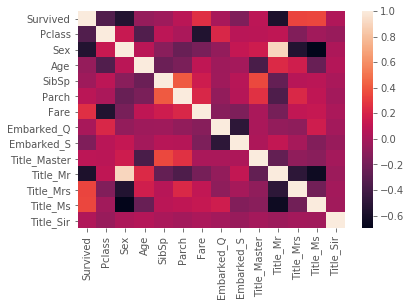

In [11]:
sns.heatmap(df.corr())

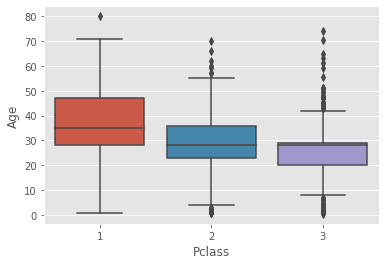

In [12]:
sns.boxplot(df['Pclass'], df['Age'])

In [13]:
survival = df_noDrop.groupby('Survived').mean().T
survival[0] = min_max_scaler.fit_transform(survival[0].values.reshape(-1,1))
survival[1] = min_max_scaler.fit_transform(survival[1].values.reshape(-1,1))

In [14]:
# Avg value of all columns grouped by Survived column; values normalized
survival

Survived,0,1
Pclass,0.084317,0.040241
Sex,0.033302,0.020604
Age,1.000000,0.584564
SibSp,0.018440,0.009728
Parch,0.010979,0.009547
Fare,0.736570,1.000000
Embarked_C,0.004549,0.005559
Embarked_Q,0.002851,0.001752
Embarked_S,0.025902,0.013172
Title_Lady,0.000000,0.000000


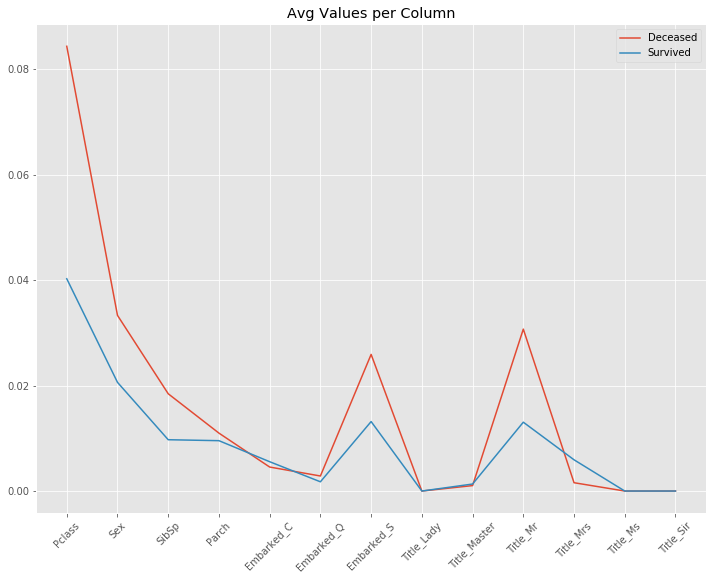

In [15]:
fig, ax = plt.subplots(figsize=(12,9))

# Drop columns [[2, 5]] / ['Age', 'Fare'] due large values
ax.plot(survival.drop(survival.index[[2, 5]]).index, 
        survival.drop(survival.index[[2, 5]])[0], label='Deceased')

ax.plot(survival.drop(survival.index[[2, 5]]).index, 
        survival.drop(survival.index[[2, 5]])[1], label='Survived')

plt.title('Avg Values per Column')
plt.xticks(rotation=45)
plt.legend();

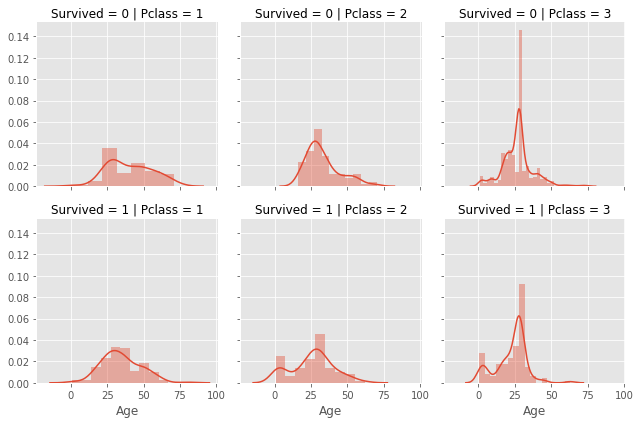

In [16]:
g = sns.FacetGrid(df, row='Survived', col='Pclass')
g.map(sns.distplot, "Age")

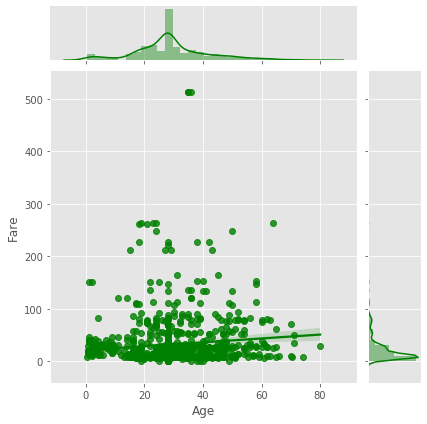

In [17]:
sns.jointplot(data=df, x='Age', y='Fare', kind='reg', color='g')